In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Activation, SpatialDropout1D, UpSampling1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", tensorflow.keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Python:  3.9.0 (default, Nov  8 2020, 11:02:52) 
[Clang 12.0.0 (clang-1200.0.32.21)]
pandas:  1.2.3
numpy:  1.19.4
seaborn:  0.11.1
matplotlib:  3.3.4
sklearn:  0.24.2
Keras:  2.6.0
Tensorflow:  2.6.0


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()

        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()


In [3]:
def normalize(df):
    """Normalize the DF using min/max"""
    scaler = MinMaxScaler(feature_range=(-1, 1))
    dates_scaled = scaler.fit_transform(df['Date'].values.reshape(-1, 1))

    return dates_scaled

def std_normalize(columns, df):
    """Normalize the DF using min/max"""
    for column in columns:
        scaler = StandardScaler()
        df[column]= scaler.fit_transform(df[column].values.reshape(-1, 1))

In [4]:
tensorlogs = ["creditcard",
              "CombinedMacroSectorv4"] #2

dataFilePaths = ['data/creditcard.csv',
                 'data/CombinedMacroSectorv4.csv']

colPlots = ['Amount',
            'Real Estate']

i=0
col = colPlots[i]

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)

missing_values = ["n/a", "na", "NaN", "--", "null"]
df = pd.read_csv(dataFilePath, sep=",", na_values = missing_values, index_col=None)
print(df.shape)
df.head()

tensorlog:  creditcard
dataFilePath:  data/creditcard.csv
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [6]:
if i == 0:
    df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
    df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
else:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Time'] = normalize(df)
    df['Class'] = df['Recession']
    std_normalize(["Oil", "Inflation", "CPI", "Dollar Index", "GDP", "Unemployment", "Energy", "Gold",
    "Materials", "Industrials", "Customer Discretionary", "Consumer Staples", "Health",
    "Financials", "Technology", "Telecommunications", "Utilities", "Real Estate", "Spy"], df)
    df.drop(['Date'], axis=1, inplace=True)
    df.drop(['Cycle'], axis=1, inplace=True)
    df.drop(['Gold'], axis=1, inplace=True)

In [7]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [8]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,1.641931,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,1.641952,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.641974,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,1.641974,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0
284806,1.642058,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0.514355,0


In [9]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

anomalies.shape, normal.shape

((492, 31), (284315, 31))

In [10]:

for f in range(0, 20):
    normal = normal.iloc[np.random.permutation(len(normal))]


data_set = pd.concat([normal[:2000], anomalies])

x_train, x_test = train_test_split(data_set, test_size = 0.4, random_state = 42)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

plot_test = x_test[['Time', col]]

y_train = x_train["Class"]
y_test = x_test["Class"]

x_train.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
81,-1.995488,1.147369,0.059035,0.263632,1.211023,-0.044096,0.301067,-0.132960,0.227885,0.252191,...,-0.087813,-0.110756,-0.097771,-0.323374,0.633279,-0.305328,0.027394,-0.000580,-0.326562,0
101,-1.995151,-0.770196,0.483572,1.901072,-0.001876,0.024245,-1.171903,0.666483,-0.094603,-0.136666,...,-0.057336,-0.155801,0.018108,0.941555,-0.168582,0.056171,0.058979,0.134188,-0.263832,0
131,-1.994856,-0.888004,0.913670,1.146088,0.656290,0.677272,-0.326211,0.888811,-0.341848,-0.523849,...,0.107833,0.661993,-0.004713,0.031097,-0.140882,-0.373698,-0.157921,0.076529,-0.329641,0
192,-1.993951,-0.724910,0.073475,1.739547,0.758588,0.229543,2.422069,0.196688,0.861076,0.099102,...,0.188696,0.738515,0.145933,-1.032186,-0.087511,-0.221063,0.108168,0.011785,0.098554,0
623,-1.986644,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758,1
648,-1.986244,-0.946412,0.609500,1.201710,0.113074,-0.210132,-0.954009,0.130325,0.293270,-0.579076,...,-0.036421,-0.266529,-0.038869,0.481943,-0.277006,0.949985,-0.079616,-0.016606,-0.279465,0
776,-1.984243,1.222874,-0.070299,-1.488572,-0.079898,2.111507,3.465646,-0.637466,0.898122,0.459247,...,-0.223690,-0.594069,-0.145533,0.942844,0.699800,0.424816,0.000268,0.039227,-0.235046,0
1047,-1.979905,-2.496329,1.157444,3.770236,-0.230246,0.007065,0.506341,1.629152,-2.267294,4.304904,...,-0.594643,0.105965,-0.558559,0.732507,0.069949,-0.030734,-2.887661,-1.683655,-0.339756,0
1101,-1.978600,1.111712,0.215379,0.355265,1.014603,-0.145608,-0.284154,0.060931,0.037710,-0.289567,...,0.129749,0.378383,-0.070872,0.236140,0.549833,-0.330397,0.023216,0.011639,-0.269150,0
1552,-1.970934,-1.912896,-1.409519,2.182004,0.468684,0.136955,0.069965,0.650129,0.131006,0.102612,...,0.446602,0.601013,0.539556,-0.040612,0.354624,-0.437351,-0.197436,-0.080706,0.910166,0


In [11]:
a = x_train[x_train["Class"] == 1]
n = x_train[x_train["Class"] == 0]

a.shape, n.shape

((294, 31), (1201, 31))

In [12]:

a = x_test[x_test["Class"] == 1]
n = x_test[x_test["Class"] == 0]

a.shape, n.shape

((198, 31), (799, 31))

In [13]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))

Shapes:
x_train:(1495, 31)
y_train:(1495,)

x_test:(997, 31)
y_test:(997,)



In [14]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)

y_train = tensorflow.keras.utils.to_categorical(y_train, 2)
y_test = tensorflow.keras.utils.to_categorical(y_test, 2)

In [15]:
input_layer = Input(shape=(input_shape))

#Series of temporal convolutional layers with dilations increasing by powers of 2.
conv_1 = Conv1D(filters=128, kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

#Dropout layer after each 1D-convolutional layer
drop_1 = SpatialDropout1D(0.05)(conv_1)

conv_2 = Conv1D(filters=128, kernel_size=2, dilation_rate=2,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_1)

drop_2 = SpatialDropout1D(0.05)(conv_2)

conv_3 = Conv1D(filters=128, kernel_size=2, dilation_rate=4,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_2)

drop_3 = SpatialDropout1D(0.05)(conv_3)

conv_4 = Conv1D(filters=128, kernel_size=2, dilation_rate=8,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(drop_3)

drop_4 = SpatialDropout1D(0.05)(conv_4)

#Flatten layer to feed into the output layer
flat = Flatten()(drop_4)

output_layer = Dense(2, activation='softmax')(flat)

TCN = Model(inputs=input_layer, outputs=output_layer)

In [16]:

TCN.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(lr=0.002),
              metrics=['mae', 'accuracy'])

checkpointer = ModelCheckpoint(filepath='model_TCN_{0}.h5'.format(tensorlog),
                               verbose=0,
                               save_best_only=True)

TCN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 31, 128)           384       
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 31, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31, 128)           32896     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 31, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31, 128)           32896     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 31, 128)           0     

/usr/local/Cellar/python@3.9/3.9.0_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:

TCN.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks = [TensorBoard(log_dir='../logs/{0}'.format(tensorlog))])

Epoch 1/10
12/12 [==============================] - 3s 113ms/step - loss: 6.8128 - mae: 0.2636 - accuracy: 0.9438 - val_loss: 4.3910 - val_mae: 0.1161 - val_accuracy: 0.9599
Epoch 2/10
12/12 [==============================] - 1s 72ms/step - loss: 3.1070 - mae: 0.1011 - accuracy: 0.9645 - val_loss: 1.8538 - val_mae: 0.1221 - val_accuracy: 0.9579
Epoch 3/10
12/12 [==============================] - 1s 75ms/step - loss: 1.2492 - mae: 0.1124 - accuracy: 0.9639 - val_loss: 0.6980 - val_mae: 0.1149 - val_accuracy: 0.9569
Epoch 4/10
12/12 [==============================] - 1s 74ms/step - loss: 0.4550 - mae: 0.1096 - accuracy: 0.9639 - val_loss: 0.2571 - val_mae: 0.0947 - val_accuracy: 0.9468
Epoch 5/10
12/12 [==============================] - 1s 89ms/step - loss: 0.1718 - mae: 0.0913 - accuracy: 0.9592 - val_loss: 0.1130 - val_mae: 0.0818 - val_accuracy: 0.9519
Epoch 6/10
12/12 [==============================] - 1s 88ms/step - loss: 0.0834 - mae: 0.0857 - accuracy: 0.9639 - val_loss: 0.0710 - 

In [18]:
score = TCN.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05676983296871185
Test accuracy: 0.08276111632585526


In [19]:
preds = TCN.predict(x_test)
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score(y_pred, y_test)
print("AUC: {:.2%}".format (auc))

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 96.50%


In [20]:
#print(real_estate)

y_label = np.argmax(y_pred, axis=1)

adf = pd.DataFrame({'Time': plot_test['Time'], 'observation': plot_test[col],
                    'anomaly': y_label})

anom = adf.loc[adf['anomaly'] == 1]

anom.head(25)

,Time,observation,anomaly
541,-1.988034,-0.353229,1
4920,-1.902623,0.606031,1
6108,-1.849472,-0.117342,1
6329,-1.838248,-0.349231,1
6331,-1.838101,-0.349231,1
6427,-1.836332,-0.349231,1
6446,-1.835027,-0.349231,1
6472,-1.833595,-0.349231,1
6529,-1.830415,-0.349231,1
6609,-1.826224,-0.349231,1


Text(0.5, 1.0, 'Time Series of value by date time')

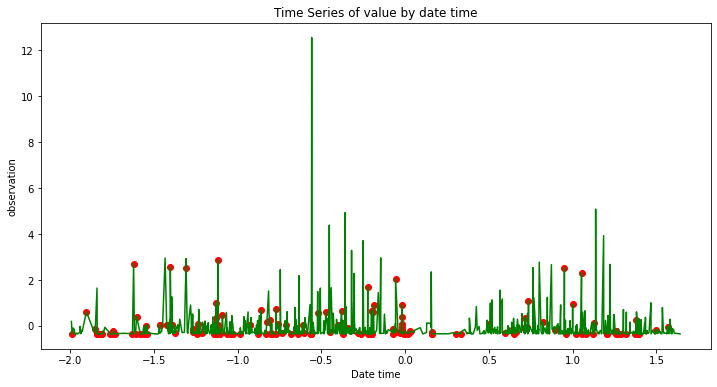

In [21]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Time'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Time'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

In [22]:
#fig, (ax1) = plt.subplots(ncols=1, figsize=(24, 16))
#ax1.set_title('Scaled')
#sns.kdeplot(real_estate, ax=ax1)

In [23]:
#fig, (ax1) = plt.subplots(ncols=1, figsize=(24, 16))
#ax1.set_title('Prediction')
#sns.kdeplot(real_estate, ax=ax1)
#plt.plot(y_pred, color='red')

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       799
           1       0.98      0.81      0.88       198

   micro avg       0.96      0.96      0.96       997
   macro avg       0.96      0.90      0.93       997
weighted avg       0.96      0.96      0.96       997
 samples avg       0.96      0.96      0.96       997



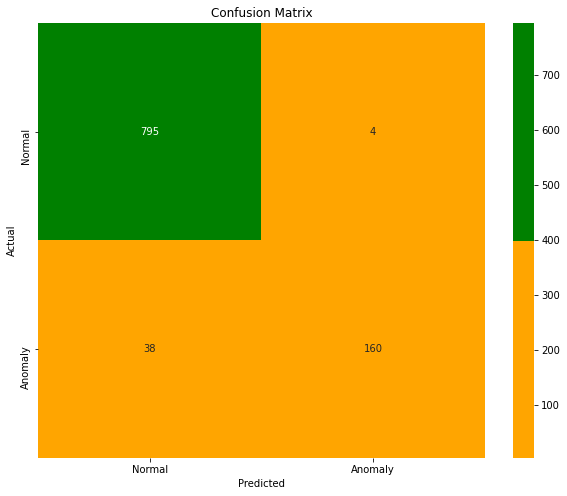

In [25]:
viz = Visualization()
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
viz.draw_confusion_matrix(y_test2, y_pred2)